In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy.stats import norm
from scipy.special import expit

from models.multiGaussian import MultiGaussianAdaptedSkiRental
from models.varianceAware import VarianceAwareSkiRental
from models.expectedCost import ExpectedCostSkiRental
from models.bayesian import BayesianSkiRental
from models.hybrid import HybridVarianceAwareSkiRental, HybridVarianceAwareSkiRentalWithScaling
from models.gaussianNoise import GaussianNoiseSkiRental
from models.bayesianDiscrete import DiscreteBayesianSkiRental


In [2]:
import logging
logging.getLogger("pymc").setLevel(logging.ERROR)
logging.getLogger("pytensor").setLevel(logging.ERROR)


 # Experiment 1 

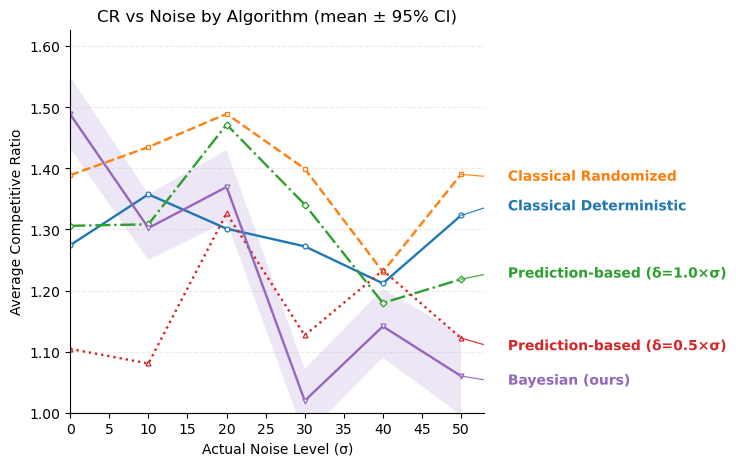

Saved: figs-final/exp1.png


In [ ]:
# -------------------------------------------------
# (6) 플로팅: 선 끝 라벨링(legend 제거, PNG만 저장) — 수평 연장 제거 버전
# -------------------------------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.ticker import MaxNLocator, FuncFormatter

# ===== 데이터 준비: agg 없으면 샘플 생성 =====
if 'agg' not in globals():
    np.random.seed(0)
    algos = [
        "Classical Deterministic",
        "Classical Randomized",
        "Prediction-based (δ=1.0×σ)",
        "Prediction-based (δ=0.5×σ)",
        "Bayesian (ours)"
    ]
    # 일부 알고리즘은 50까지만, 일부는 100까지 만들어 상황 재현
    rows = []
    for algo in algos:
        if algo in ["Classical Deterministic", "Bayesian (ours)"]:
            noise_levels = np.arange(0, 101, 10)   # 0..100
        else:
            noise_levels = np.arange(0, 51, 10)    # 0..50 (이후 없음)

        mean   = 1.05 + 0.45 * np.random.rand(len(noise_levels))
        ci_low = mean - 0.05 - 0.02 * np.random.rand(len(noise_levels))
        ci_high= mean + 0.05 + 0.02 * np.random.rand(len(noise_levels))
        for n, m, lo, hi in zip(noise_levels, mean, ci_low, ci_high):
            rows.append((algo, n, m, lo, hi))
    agg = pd.DataFrame(rows, columns=["algorithm", "noise", "mean", "ci_low", "ci_high"])

# ===== 스타일/순서 =====
order      = agg["algorithm"].unique().tolist()
palette    = list(plt.get_cmap("tab10").colors)
linestyles = ["-", "--", "-.", ":"]
markers    = ["o", "s", "D", "^", "v", "X", "P"]

# ===== 플롯 시작 =====
fig, ax = plt.subplots(figsize=(7.6, 4.8))
end_points = []  # (algo, x_last, y_last, color)

for i, algo in enumerate(order):
    tmp = agg[agg["algorithm"] == algo].copy()
    if tmp.empty:
        continue

    # 안전: numeric + 정렬
    for col in ["noise", "mean", "ci_low", "ci_high"]:
        tmp[col] = pd.to_numeric(tmp[col], errors="coerce")
    tmp = tmp.dropna(subset=["noise", "mean"]).sort_values("noise")

    # >>> 핵심: 패딩/재색인/보간으로 '뒤를 채우지 않음' (수평선 방지)
    x = tmp["noise"].to_numpy()
    y = tmp["mean"].to_numpy()
    lo = tmp["ci_low"].to_numpy()
    hi = tmp["ci_high"].to_numpy()

    color = palette[i % len(palette)]
    ls    = linestyles[i % len(linestyles)]
    mk    = markers[i % len(markers)]

    # 우리 모델만 신뢰구간 음영 (있는 구간까지만)
    if algo == "Bayesian (ours)":
        ax.fill_between(x, lo, hi, alpha=0.16, facecolor=color, edgecolor="none")

    # 모든 모델 라인 + 마커 (있는 구간까지만)
    ax.plot(x, y, linewidth=1.7, linestyle=ls, marker=mk, markersize=3.5,
            markerfacecolor="white", markeredgewidth=0.9, color=color)

    # 라벨용 끝점 = 실제 마지막 데이터 지점
    x_last = float(x[-1])
    y_last = float(y[-1])
    end_points.append((algo, x_last, y_last, color))

# ===== 축/눈금/타이틀 =====
ax.set_xlabel("Actual Noise Level (σ)")
ax.set_ylabel("Average Competitive Ratio")
ax.set_title("CR vs Noise by Algorithm (mean ± 95% CI)")
ax.set_xlim(0, 53)
ax.set_xticks(np.arange(0, 53, 10))
y_min = 1.0
y_max = min(2.5, float(agg["ci_high"].max()) * 1.05)
ax.set_ylim(y_min, y_max)
ax.xaxis.set_major_locator(MaxNLocator(nbins=11, integer=True))
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.2f}"))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.25, linestyle="--")
ax.grid(axis='x', visible=False)

# ===== 선 끝 라벨링 (충돌 방지) =====
end_points.sort(key=lambda t: t[2])  # y 기준 정렬
yrange  = y_max - y_min
xpad    = 6.0
min_sep = 0.035 * yrange
base_dy = 0.012 * yrange
N = len(end_points)

lin_offsets = np.linspace(-base_dy, base_dy, num=max(N, 1))
desired_y = {ep[0]: np.clip(ep[2] + off, y_min + 0.01*yrange, y_max - 0.01*yrange)
             for off, ep in zip(lin_offsets, end_points)}

group_nudge = {
    "Classical Deterministic":      +0.018 * yrange,
    "Classical Randomized":         -0.018 * yrange,
    "Prediction-based (δ=1.0×σ)":   +0.015 * yrange,
    "Prediction-based (δ=0.5×σ)":   -0.015 * yrange,
    "Bayesian (ours)":               0.0,
}
for algo, _, _, _ in end_points:
    desired_y[algo] = float(np.clip(
        desired_y[algo] + group_nudge.get(algo, 0.0),
        y_min + 0.01*yrange, y_max - 0.01*yrange
    ))

# 아래→위, 위→아래 스윕
placed = []
for algo, x_last, y_last, color in end_points:
    y_tgt = desired_y[algo]
    if placed:
        y_tgt = max(y_tgt, placed[-1][1] + min_sep)
    y_tgt = min(y_tgt, y_max - 0.01*yrange)
    placed.append((algo, y_tgt))
for i in range(len(placed)-2, -1, -1):
    algo, y_tgt = placed[i]
    _, y_above = placed[i+1]
    if y_above - y_tgt < min_sep:
        placed[i] = (algo, max(y_min + 0.01*yrange, y_above - min_sep))

# 연결선 + 텍스트
pos_map = dict(placed)
for algo, x_last, y_last, color in end_points:
    y_lab = pos_map.get(algo, y_last)
    ax.plot([x_last, x_last + 0.6*xpad], [y_last, y_lab],
            color=color, linewidth=0.9, alpha=0.9)
    ax.text(x_last + xpad, y_lab, algo, color=color, fontsize=10,
            va='center', ha='left', fontweight='semibold',
            path_effects=[pe.withStroke(linewidth=3, foreground="white", alpha=0.9)])

fig.tight_layout(pad=1.2)

# ===== 저장(PNG만) =====
os.makedirs("figs-final", exist_ok=True)
out_png = "figs-final/exp1.png"
fig.savefig(out_png, bbox_inches="tight")
plt.show()
print(f"Saved: {out_png}")


# Experiment 2

✅ Saved: figs-bosun/exp2final.png (plot type = boxplot)


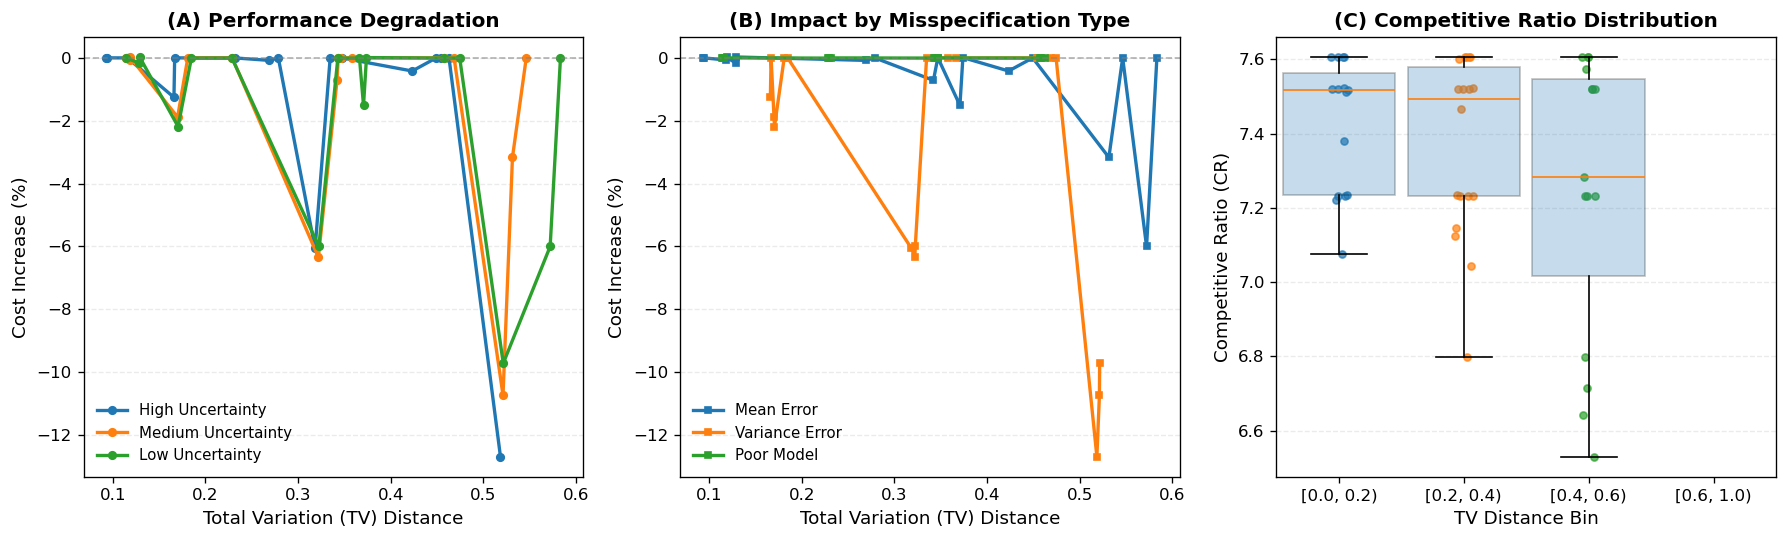

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# === 데이터 로드 ===
if 'df' not in globals():
    df = pd.read_csv("figs-bosun/exp3.csv")

for c in [
    "tv_distance", "pct_cost_increase", "mean_cr", "std_cr", "p95_cr", "p99_cr",
    "failure_rate", "severe_fail", "t_star", "t_star_optimal", "threshold_error",
    "avg_cost", "baseline_cost", "regret"
]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

def plot_focused_three_safe(
    d,
    tv_edges=(0.0, 0.2, 0.4, 0.6, 1.01),
    outfile="figs-bosun/exp3_FIXEDRULE_FOCUSED_3PLOTS.png"
):
    d = d.copy()
    configs = list(d["config"].dropna().unique())
    order_key = {"High":0, "Medium":1, "Low":2}
    configs_sorted = sorted(configs, key=lambda s: order_key.get(s.split()[0], 99))

    fig, (axA, axB, axC) = plt.subplots(1, 3, figsize=(15, 4.6))

    # --- (A) Performance Degradation ---
    for cfg in configs_sorted:
        sub = d[d["config"] == cfg].sort_values("tv_distance")
        axA.plot(
            sub["tv_distance"], sub["pct_cost_increase"],
            marker="o", linewidth=2.0, markersize=4.5,
            label=cfg.split("(")[0].strip()
        )
    axA.axhline(0, color="gray", linestyle="--", linewidth=1.0, alpha=0.6)
    axA.set_title("(A) Performance Degradation", fontweight="bold")
    axA.set_xlabel("Total Variation (TV) Distance")
    axA.set_ylabel("Cost Increase (%)")
    axA.grid(axis="y", alpha=0.25, linestyle="--")
    axA.legend(frameon=False)

    # --- (B) Impact by Type ---
    type_order = ["Mean Error", "Variance Error", "Poor Model"]
    for tp in type_order:
        sub = d[d["scenario_type"] == tp].sort_values("tv_distance")
        if len(sub) > 0:
            axB.plot(
                sub["tv_distance"], sub["pct_cost_increase"],
                marker="s", linewidth=2.0, markersize=4.0,
                label=tp
            )
    axB.axhline(0, color="gray", linestyle="--", linewidth=1.0, alpha=0.6)
    axB.set_title("(B) Impact by Misspecification Type", fontweight="bold")
    axB.set_xlabel("Total Variation (TV) Distance")
    axB.set_ylabel("Cost Increase (%)")
    axB.grid(axis="y", alpha=0.25, linestyle="--")
    axB.legend(frameon=False)

    # --- (C) CR Distribution ---
    tv_edges = np.asarray(tv_edges, dtype=float)
    tv_labels = [f"[{tv_edges[i]:.1f}, {tv_edges[i+1]:.1f})" for i in range(len(tv_edges)-1)]
    d["tv_bin"] = pd.cut(d["tv_distance"], bins=tv_edges, labels=tv_labels, include_lowest=True)

    bin_series = []
    for lbl in tv_labels:
        vals = d.loc[d["tv_bin"] == lbl, "mean_cr"]
        vals = vals[np.isfinite(vals)]
        bin_series.append(vals.values)

    positions = np.arange(1, len(tv_labels) + 1)

    # --- 자동 fallback ---
    safe_data = []
    has_violin = True
    for vals in bin_series:
        arr = np.asarray(vals, dtype=float)
        if arr.size < 2:
            has_violin = False
        safe_data.append(arr if arr.size > 0 else np.array([np.nan, np.nan]))

    if has_violin:
        parts = axC.violinplot(safe_data, positions=positions, widths=0.9,
                               showmeans=False, showmedians=True, showextrema=False)
        for pc in parts['bodies']:
            pc.set_alpha(0.25)
    else:
        bp = axC.boxplot(safe_data, positions=positions, widths=0.9,
                         showfliers=False, patch_artist=True)
        for patch in bp['boxes']:
            patch.set_alpha(0.25)

    # --- scatter로 실제 값 시각화 ---
    rng = np.random.default_rng(42)
    for pos, vals in zip(positions, bin_series):
        if vals.size == 0:
            continue
        x = pos + (rng.random(vals.size) - 0.5) * 0.15
        axC.scatter(x, vals, s=18, alpha=0.7)

    axC.set_title("(C) Competitive Ratio Distribution", fontweight="bold")
    axC.set_xlabel("TV Distance Bin")
    axC.set_ylabel("Competitive Ratio (CR)")
    axC.set_xticks(positions)
    axC.set_xticklabels(tv_labels)
    axC.grid(axis="y", alpha=0.25, linestyle="--")
    axC.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.1f}" if v < 10 else f"{int(v)}"))

    fig.tight_layout()
    os.makedirs(os.path.dirname(outfile), exist_ok=True)
    fig.savefig(outfile, bbox_inches="tight", dpi=300)
    print(f" Saved: {outfile} (plot type = {'violin' if has_violin else 'boxplot'})")

    return fig

# === 실행 ===
fig = plot_focused_three_safe(
    df,
    tv_edges=(0.0, 0.2, 0.4, 0.6, 1.01),
    outfile="figs-bosun/exp2final.png"
)


# Experiment 3

In [52]:

# ======= End-label + Shadow 스타일 플롯 (prediction_multiplier vs cr) =======
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.ticker import MaxNLocator, FuncFormatter

# 1) 집계: mean ± 95% CI
agg = (
    df.groupby(["algorithm", "prediction_multiplier"])["cr"]
      .agg(mean="mean", sem="sem", count="count")
      .reset_index()
)
agg["ci95"]   = 1.96 * agg["sem"].fillna(0)
agg["ci_low"] = agg["mean"] - agg["ci95"]
agg["ci_high"] = agg["mean"] + agg["ci95"]

# 2) 스타일 준비
order      = agg["algorithm"].drop_duplicates().tolist()
palette    = list(plt.cm.tab10.colors)
linestyles = ["-", "--", "-.", ":"]
markers    = ["o", "s", "D", "^", "v", "P", "X", "*"]

# 3) 플로팅
fig, ax = plt.subplots(figsize=(7.2, 4.6))
end_points = []  # (algo, x_last, y_last, color)

for i, algo in enumerate(order):
    tmp = agg[agg["algorithm"] == algo].sort_values("prediction_multiplier")
    if tmp.empty:
        continue

    color = palette[i % len(palette)]
    ls    = linestyles[i % len(linestyles)]
    mk    = markers[i % len(markers)]

    # 신뢰구간 음영
    ax.fill_between(
        tmp["prediction_multiplier"].values, tmp["ci_low"].values, tmp["ci_high"].values,
        alpha=0.12, facecolor=color, edgecolor="none"
    )

    # 평균 라인 + 마커
    ax.plot(
        tmp["prediction_multiplier"].values, tmp["mean"].values,
        linewidth=1.7, linestyle=ls, marker=mk, markersize=3.5,
        markerfacecolor="white", markeredgewidth=0.9,
        color=color
    )

    # 마지막 점 저장(라벨용)
    x_last = float(tmp["prediction_multiplier"].values[-1])
    y_last = float(tmp["mean"].values[-1])
    end_points.append((algo, x_last, y_last, color))

# 4) 축/범위
ax.set_xscale("log")
ax.set_xlabel("Prediction Multiplier (log scale)")
ax.set_ylabel("Average Competitive Ratio")
ax.set_title("CR vs. Prediction Multiplier (mean ± 95% CI)")

x_min, x_max = float(agg["prediction_multiplier"].min()), float(agg["prediction_multiplier"].max())
y_min = 1.0
y_max = min(2.5, float(agg["ci_high"].max()) * 1.05)
ax.set_ylim(y_min, y_max)
ax.set_xlim(x_min, x_max)  # 라벨 그린 후 오른쪽 여백 조정

ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.2f}"))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.25, linestyle="--")
ax.grid(axis='x', visible=False)

# 5) 선 끝 라벨링 (충돌 방지 + shadow 외곽선)
end_points.sort(key=lambda t: t[2])  # y값 기준 정렬
yrange = y_max - y_min

# 오른쪽 텍스트 x-padding (로그축 고려한 상대 padding)
xpad = 0.12 * (np.log10(x_max) - np.log10(x_min))
xpad_lin = 10**(np.log10(x_max) + xpad) - x_max
xpad_lin = max(xpad_lin, (x_max - x_min) * 0.08)

min_sep = 0.035 * yrange
base_dy = 0.012 * yrange

N = len(end_points)
lin_offsets = np.linspace(-base_dy, base_dy, num=N)
desired_y = {ep[0]: float(np.clip(ep[2] + off, y_min + 0.01*yrange, y_max - 0.01*yrange))
             for off, ep in zip(lin_offsets, end_points)}

# (옵션) 그룹별 미세 오프셋이 필요하면 여기에 dict 추가 가능
# group_nudge = {"Classical Deterministic": +0.018*yrange, ...}
# for algo, _, _, _ in end_points:
#     desired_y[algo] = float(np.clip(desired_y[algo] + group_nudge.get(algo, 0.0),
#                                     y_min+0.01*yrange, y_max-0.01*yrange))

# 아래→위, 위→아래 스윕으로 min_sep 확보
placed = []
for algo, x_last, y_last, color in end_points:
    y_tgt = desired_y[algo]
    if placed:
        y_tgt = max(y_tgt, placed[-1][1] + min_sep)
    y_tgt = min(y_tgt, y_max - 0.01*yrange)
    placed.append((algo, y_tgt))
for i in range(len(placed)-2, -1, -1):
    algo, y_tgt = placed[i]
    _, y_above = placed[i+1]
    if y_above - y_tgt < min_sep:
        placed[i] = (algo, max(y_min + 0.01*yrange, y_above - min_sep))

pos_map = dict(placed)

# 연결선 + 텍스트 (shadow 외곽선)
for algo, x_last, y_last, color in end_points:
    y_lab = pos_map[algo]

    # 연결선(선 끝 → 라벨)
    ax.plot([x_last, x_last + 0.6*xpad_lin], [y_last, y_lab],
            color=color, linewidth=0.9, alpha=0.9)

    # 라벨 텍스트(흰 외곽선)
    ax.text(
        x_last + xpad_lin, y_lab, algo,
        color=color, fontsize=11, va='center', ha='left', fontweight='semibold',
        path_effects=[pe.withStroke(linewidth=3, foreground="white", alpha=0.9)]
    )

# 라벨 공간 위해 오른쪽 여백 확장
ax.set_xlim(x_min, x_max + xpad_lin * 2.0)

fig.tight_layout(pad=1.2)

# 6) 저장
os.makedirs("figs-bosun", exist_ok=True)
out_pdf = "figs-bosun/exp_cr_vs_multiplier_endlabels.pdf"
out_png = "figs-bosun/exp2_fffinal.png"
fig.savefig(out_pdf, bbox_inches="tight")
fig.savefig(out_png, bbox_inches="tight", dpi=600)
plt.show()

print(f"Saved: {out_pdf}\nSaved: {out_png}")

KeyError: 'algorithm'

# Experiment 4

[t*] Bi-modal: 81, Tri-modal: 81, Seasonal: 81  (with b=25, M=80)


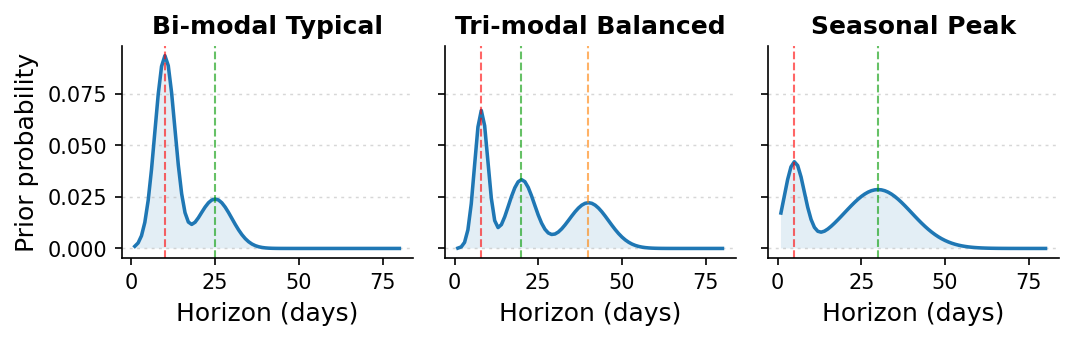

Saved: figs-final/experiment4.png


In [ ]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.stats import norm

# ---------------------------
# 기본 스타일(논문형)
# ---------------------------
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": [
        "DejaVu Sans",        # 기본
        "Helvetica",          # macOS
        "Arial",              # Windows fallback
    ],
    "font.weight": "regular",
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.titleweight": "semibold",
    "axes.labelweight": "regular",
    "lines.linewidth": 1.7,
    "savefig.dpi": 600,
    "figure.dpi": 150,
})



os.makedirs("figs-bosun", exist_ok=True)

# ---------------------------
# 유틸: prior 생성 & 정규화
# ---------------------------
def discretize_gaussian_mixture(M, components):
    """
    components: list of (weight, mu, sigma)
    returns prior over k=1..M (np.array length M)
    """
    x = np.arange(1, M+1)
    p = np.zeros_like(x, dtype=float)
    for w, mu, sigma in components:
        p += w * norm.pdf(x, loc=mu, scale=sigma)
    s = p.sum()
    return p / s if s > 0 else np.ones(M)/M

def discretize_trimodal(M, modes, stds, weights):
    x = np.arange(1, M+1)
    p = np.zeros(M, dtype=float)
    for w, m, s in zip(weights, modes, stds):
        p += w * norm.pdf(x, loc=m, scale=s)
    s = p.sum()
    return p / s if s > 0 else np.ones(M)/M

# ---------------------------
# t* 계산 (Bayesian 잔여렌탈 기대비용 규칙)
# ---------------------------
def optimal_t_star(b, M, prior):
    """
    prior[k-1] = P(K=k)
    buy at first t with b <= E[min{K-t+1,b} | K>=t]
    if never, return M+1 (never buy)
    """
    prior = np.asarray(prior, dtype=float)
    prior /= prior.sum()
    # 누적 생존확률 Z_t = P[K>=t]
    Z = np.flip(np.cumsum(np.flip(prior)))  # Z[t-1] = sum_{k=t..M} prior[k-1]
    for t in range(1, M+1):
        if Z[t-1] <= 0:
            continue
        # posterior on {K>=t}: p_{t,k} = prior[k-1]/Z_t for k>=t
        # E_rent(t) = sum_{k=t..M} p_{t,k} * min{k - t + 1, b}
        ks = np.arange(t, M+1)
        post = prior[ks-1] / Z[t-1]
        rent_costs = np.minimum(ks - t + 1, b)
        E_rent = np.sum(post * rent_costs)
        if b <= E_rent:
            return t
    return M + 1  # never buy

# ---------------------------
# 케이스 정의 (논문 서술과 동일)
# ---------------------------
M = 80   # 그림 가독성을 위해 축소. 논문표현 맞추려면 60~120 권장
# !!! 텍스트의 t*를 재현하려면 b를 조정하세요 !!!
b = 25   # 예: 25 정도로 두면 10/25/30 같은 모드에서 직관적인 t*가 나옴

# (1) Bi-modal Typical: 0.7*N(10,3^2) + 0.3*N(25,5^2)
prior_bi = discretize_gaussian_mixture(
    M, components=[(0.7, 10, 3), (0.3, 25, 5)]
)

# (2) Tri-modal Balanced: equal weights at 8, 20, 40
prior_tri = discretize_trimodal(
    M, modes=[8, 20, 40], stds=[2, 4, 6], weights=[1/3, 1/3, 1/3]
)

# (3) Seasonal Peak: 0.3*N(5,3^2) + 0.7*N(30,10^2)
prior_season = discretize_gaussian_mixture(
    M, components=[(0.3, 5, 3), (0.7, 30, 10)]
)

# t* 계산
t_bi  = optimal_t_star(b, M, prior_bi)
t_tri = optimal_t_star(b, M, prior_tri)
t_sea = optimal_t_star(b, M, prior_season)

print(f"[t*] Bi-modal: {t_bi}, Tri-modal: {t_tri}, Seasonal: {t_sea}  (with b={b}, M={M})")

# ---------------------------
# 그림: 3-패널 (논문 형식)
# ---------------------------
fig, axes = plt.subplots(1, 3, figsize=(7.2, 2.4), sharey=True)

cases = [
    ("(A) Bi-modal Typical", prior_bi, [10, 25], [(1.0, 0, 0), (0, 0.6, 0)], t_bi),
    ("(B) Tri-modal Balanced", prior_tri, [8, 20, 40], [(1.0, 0, 0), (0, 0.6, 0), (1.0, 0.5, 0)], t_tri),
    ("(C) Seasonal Peak", prior_season, [5, 30], [(1.0, 0, 0), (0, 0.6, 0)], t_sea),
]

x = np.arange(1, M+1)
shadow = [pe.withStroke(linewidth=3, foreground="white", alpha=0.9)]

for ax, (title, prior, modes, mode_colors, t_star) in zip(axes, cases):
    # prior 곡선 + 리본
    ax.plot(x, prior, color="tab:blue", linewidth=1.7)
    ax.fill_between(x, 0, prior, color="tab:blue", alpha=0.12, edgecolor="none")

    # 모드 표시(점선)
    for m, c in zip(modes, mode_colors):
        ax.axvline(m, color=c, linestyle="--", linewidth=1.0, alpha=0.6)

    # t* 표시(굵은 점선 + 라벨 shadow)
    if t_star <= M:
        ax.axvline(t_star, color="tab:orange", linestyle="--", linewidth=2.0, alpha=0.9)
        ax.text(t_star+0.5, max(prior)*0.9, r"$t^\*$",
                color="tab:orange", fontsize=11, va="top", ha="left",
                path_effects=shadow)

    # 축/레이블
    ax.set_title(title)
    ax.set_xlabel("Horizon (days)")
    ax.grid(True, axis="y", linestyle=(0, (2, 3)), linewidth=0.7, alpha=0.5)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axes[0].set_ylabel("Prior probability")
fig.tight_layout()
out_png = "figs-final/experiment4.png"
fig.savefig(out_png, bbox_inches="tight")
plt.show()
print(f"Saved: {out_png}")
